In [1]:
# Connect Google Drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
## Load all ipynb files from Google Drive to Colab environment
import os
import shutil

def find_and_copy_files(src_folder, dest_folder, file_extension):
    for foldername, subfolders, filenames in os.walk(src_folder):
        for filename in filenames:
            if filename.endswith(file_extension):
                src_file = os.path.join(foldername, filename)
                dest_file = os.path.join(dest_folder, filename)
                try:
                    shutil.copy2(src_file, dest_file)  # Use shutil.copy if you don't need metadata
                    print(f"Copied: {src_file} to {dest_file}")
                except Exception as e:
                    print(f"Error copying {src_file}: {e}")

In [3]:
src_folder = '/content/gdrive/MyDrive/OWR/source'
dest_folder = '/content'
file_extension = '.ipynb'

# Call the function to find and copy files
find_and_copy_files(src_folder, dest_folder, file_extension)

Copied: /content/gdrive/MyDrive/OWR/source/input_generator/owr_input_generator.ipynb to /content/owr_input_generator.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/owr_model_v2.ipynb to /content/owr_model_v2.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/owr_segmentation_v3.ipynb to /content/owr_segmentation_v3.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/preprocessing/owr_preprocess_skew_CNN_classification.ipynb to /content/owr_preprocess_skew_CNN_classification.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/preprocessing/owr_preprocess_skew_CNN_regression.ipynb to /content/owr_preprocess_skew_CNN_regression.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/preprocessing/owr_preprocess_skew_cv.ipynb to /content/owr_preprocess_skew_cv.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/preprocessing/owr_preprocessing.ipynb to /content/owr_preprocessing.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/preprocess

In [4]:
from IPython.display import clear_output as cls

!pip install import_ipynb
import import_ipynb

cls()

In [5]:
import os
import json
import random
import matplotlib.pyplot as plt
import PIL.Image as Image
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow

from skimage.transform import hough_line, hough_line_peaks, rotate
from skimage.feature import canny
from skimage.io import imread, imsave
from skimage.color import rgb2gray
from scipy.stats import mode

from skimage.restoration import denoise_tv_chambolle

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

cls()

In [6]:
# Import Colab Models
import owr_pre_skew_cv_base as SkewCV

importing Jupyter notebook from owr_pre_skew_cv_base.ipynb


In [7]:
# Global Parameters


In [8]:
def set_OpenCV_skew_tilt_corrected(img):
  angle_range = (-5, 5)
  shear_values=(-0.2, -0.1, 0, 0.1, 0.2)

  # Skewness Correction
  angle, fixed_angle = SkewCV.cd_Hough_Transform(img, angle_range, 1.0, 0.1)

  # Update Data
  if abs(round(fixed_angle,1)) > 0.0 and abs(round(fixed_angle,1)) <= 5.0:
    img = SkewCV.cd_skewness_correction(img, angle_range, 1.0, 0.1)
  else:
    # Tilt Correction
    angle, fixed_angle = SkewCV.cd_Hough_Transform_tilt(img, shear_values)

    # Update Data
    if abs(round(fixed_angle,2)) > 0.00 and abs(round(fixed_angle,2)) <= 0.20:
      img = SkewCV.cd_tilt_correction(img, shear_values)
  return img

In [9]:
def set_CNN_skew_tilt_corrected(imgIn, skew_model, tilt_model, type):

  #skew_classes = [-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5]
  #tilt_classes = [-2., -1.,  0.,  1.,  2.]
  skew_classes = [0,  1,  2,  3,  4,  5, -5, -4, -3, -2, -1]
  tilt_classes = [0.0, 0.1, 0.2, -0.2, -0.1]

  img = cv2.resize(imgIn,(400,566))
  img = img[:,:,0] #zeroth component is the red from RGB channel ordering


  img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)

  f = cv2.dft(np.float32(img))
  fshift = np.fft.fftshift(f)
  f_abs = np.abs(fshift) + 1.0
  f_img = 20 * np.log(f_abs)

  image_arr = tf.keras.preprocessing.image.img_to_array(f_img)
  X = np.expand_dims(image_arr, axis=0)
  X_images = np.array(X)
  X_images /= 255

  imgOut =  imgIn
  if type == 'S':
    skew_prediction = skew_model.predict(X_images, verbose=None)
    skew_angle = skew_classes[np.argmax(skew_prediction, axis=1).item()]

    # print('skew:',skew_angle)

    if abs(round(skew_angle,1)) > 0.0 and abs(round(skew_angle,1)) <= 5.0:
      imgOut = SkewCV.cd_skewness_correction_cnn(imgOut, - skew_angle, 1.0, 0.1)


  if type == 'T':
    tilt_prediction = tilt_model.predict(X_images, verbose=None)
    tilt_angle = tilt_classes[np.argmax(tilt_prediction, axis=1).item()]

    # Update Data
    if abs(round(tilt_angle,2)) > 0.00 and abs(round(tilt_angle,2)) <= 0.2:
      # print('Tilt:',tilt_angle)
      imgOut = SkewCV.cd_tilt_correction_cnn(imgOut, - tilt_angle)



  return imgOut

## Testing

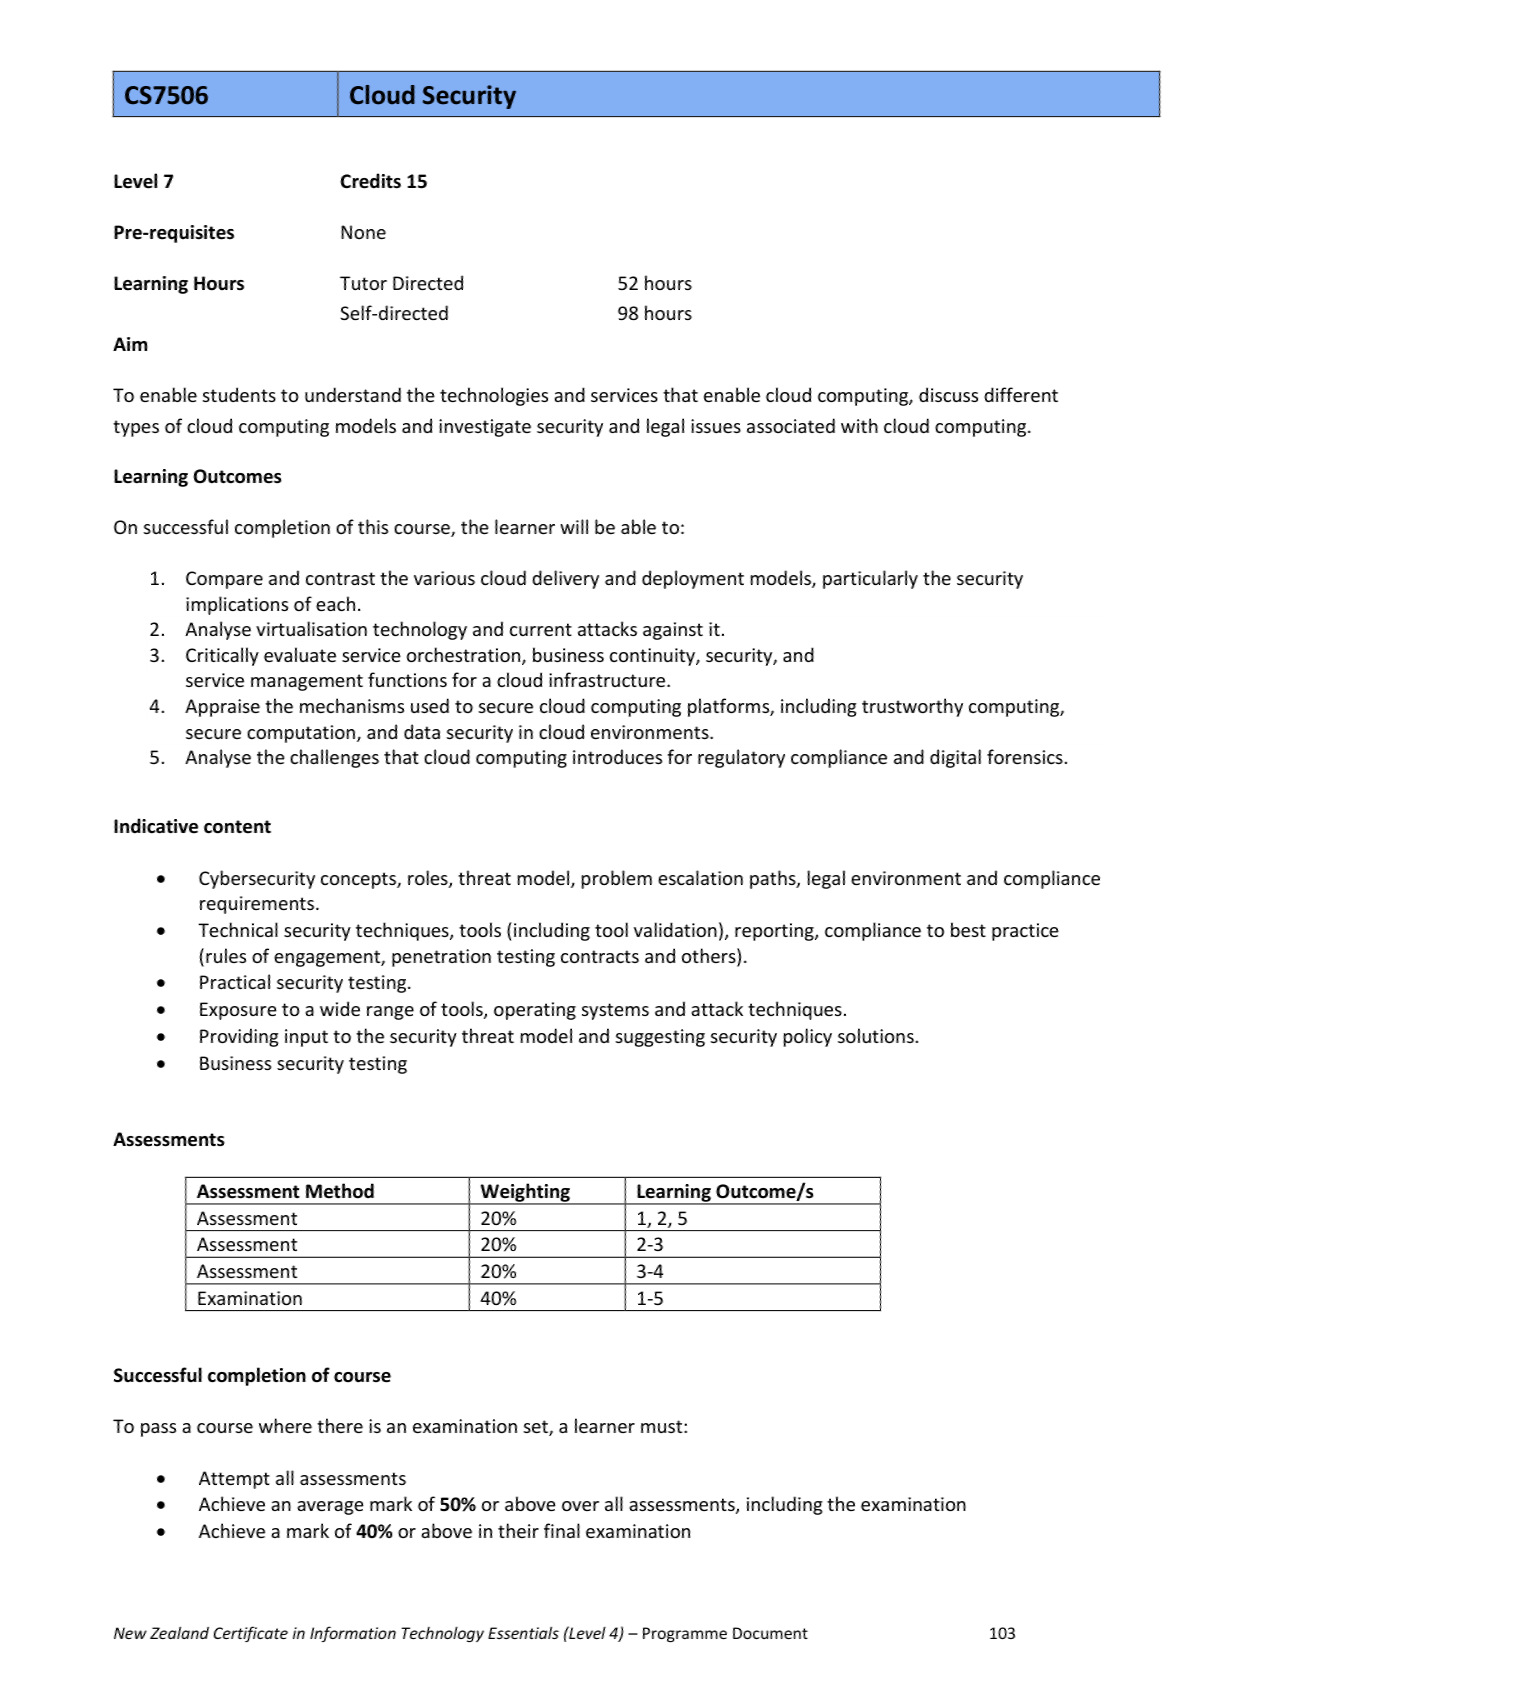

In [10]:
if __name__ == '__main__':
  import matplotlib.pyplot as plt
  import PIL.Image as Image
  import cv2
  from google.colab.patches import cv2_imshow

  img = imread('/content/gdrive/MyDrive/OWR/data/input/page_103.png')

  img = set_OpenCV_skew_tilt_corrected(img)

  cv2_imshow(img)

In [11]:
if __name__ == '__main__':
  model_skew = load_model('/content/gdrive/MyDrive/OWR/dl_models/skew_cnn_clas.h5')
  model_tilt = load_model('/content/gdrive/MyDrive/OWR/dl_models/tilted_T_cnn_cd_clas.h5')



<ipython-input-9-5a58a22795a6>:12: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)


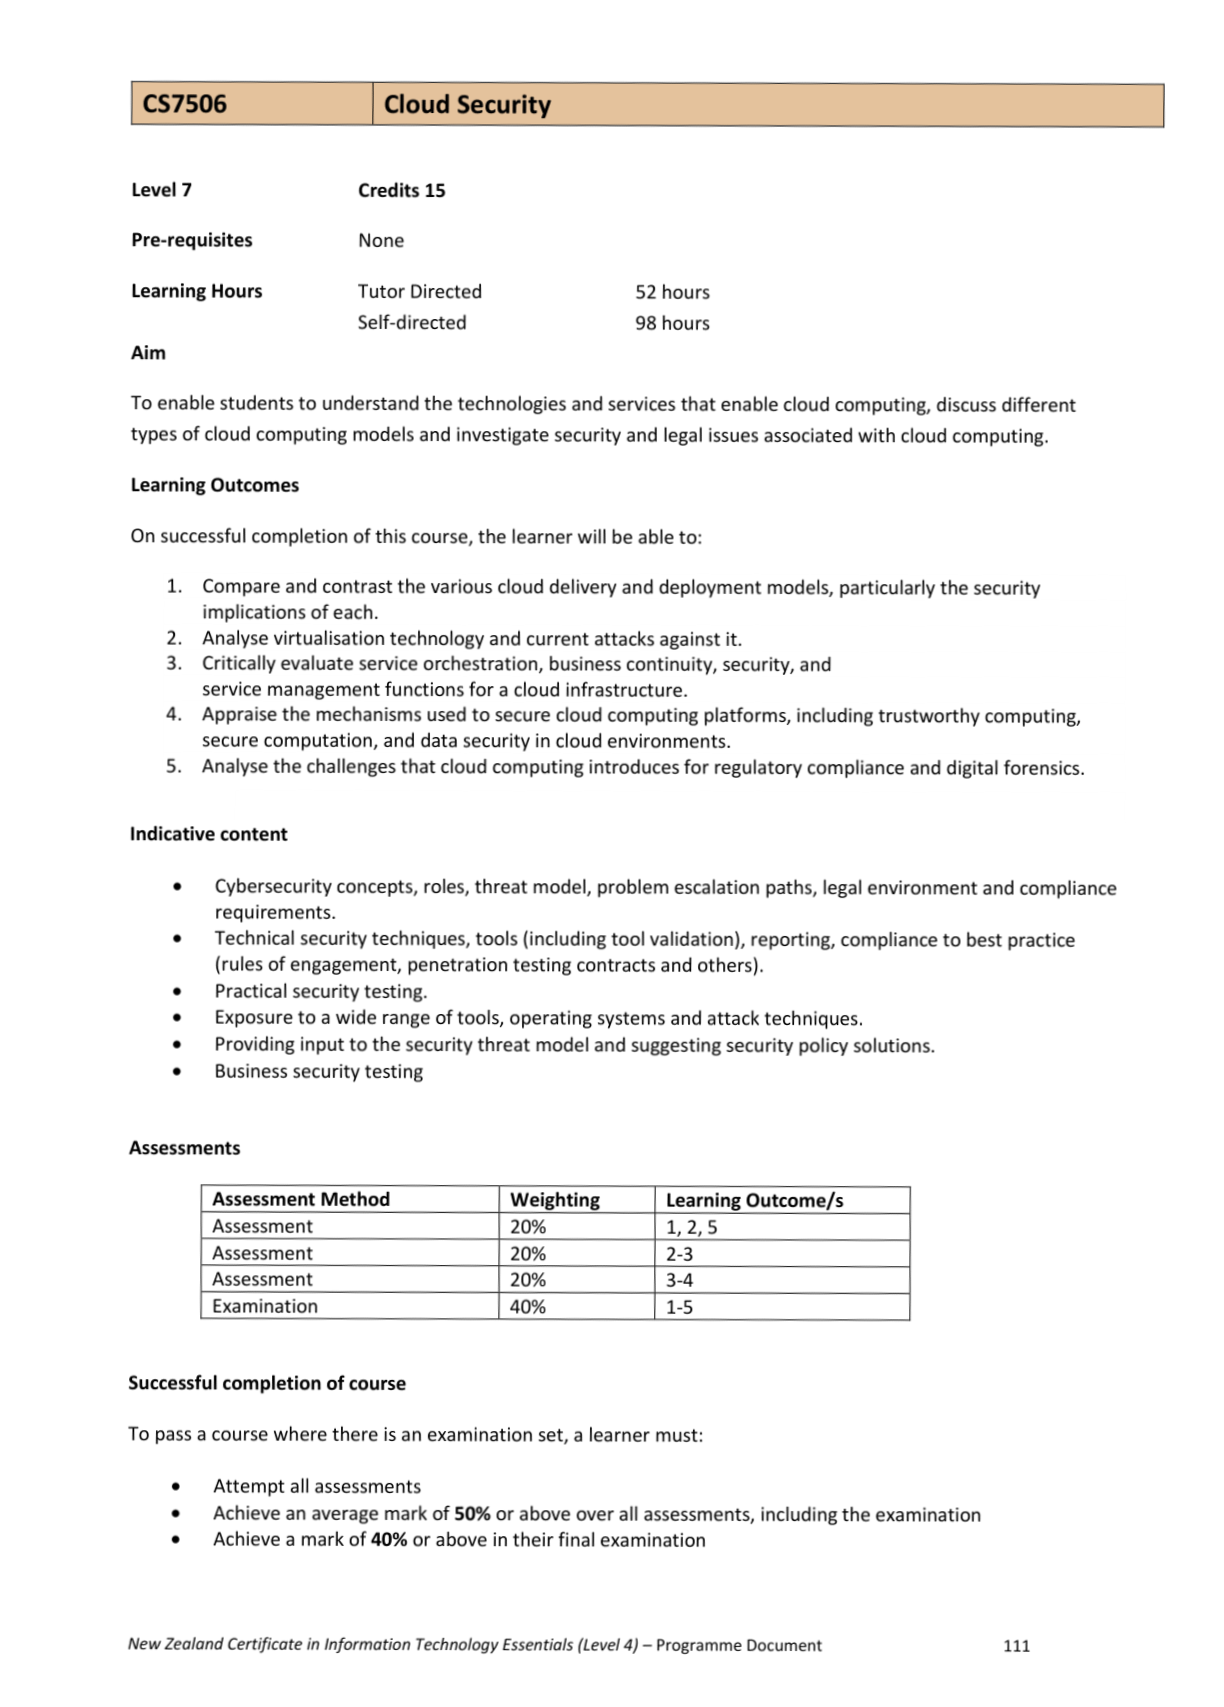

In [12]:
if __name__ == '__main__':
  import matplotlib.pyplot as plt
  import PIL.Image as Image
  import cv2
  from google.colab.patches import cv2_imshow

  img = imread('/content/gdrive/MyDrive/OWR/data/input/page_111.png')

  img1 = set_CNN_skew_tilt_corrected(img, model_skew, model_tilt,'S')

  cv2_imshow(img1)



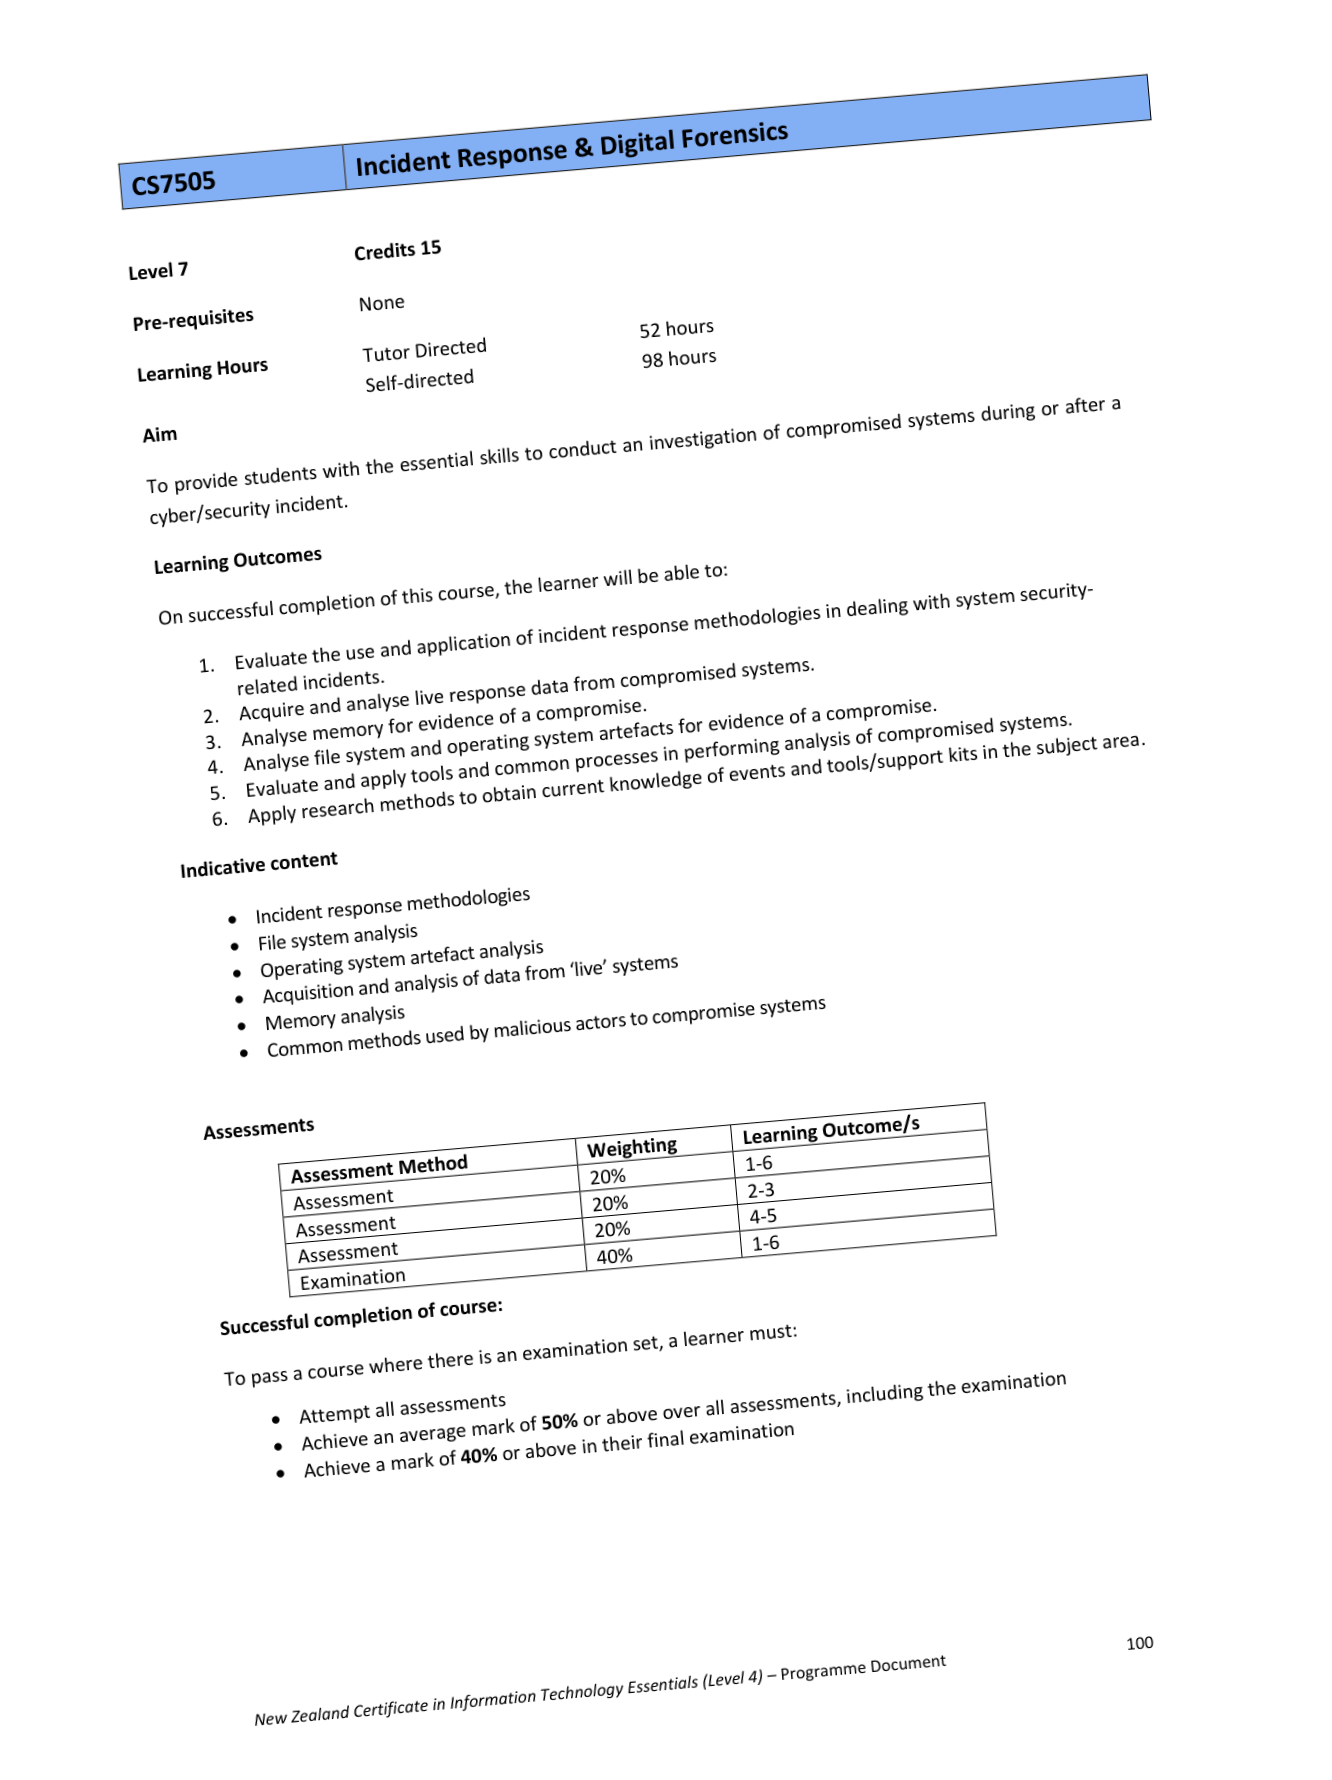

In [13]:
if __name__ == '__main__':
  img = imread('/content/gdrive/MyDrive/OWR/data/input/page_100.png')


  cv2_imshow(img)
